# PHM PROCESS BASED ON HEALTH INDEX

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import numpy as np
np.set_printoptions(suppress=True)

import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import keras 
import keras.backend as K

import wtte.weibull as weibull
import wtte.wtte as wtte

from math import log
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

seed = 42

Using TensorFlow backend.


<a name='TOC'></a>
## Table of Contents
- <a href='#training_data_import'>Training Data Import</a>
- <a href='#training_preprocessing'>Training Preprocessing</a>
    - <a href='#tr_occ'>Operating Conditions Clustering</a>
    - <a href='#tr_fe'>Feature Engineering</a>
    - <a href='#tr_rul'>Contruction of the Target Feature (RUL)</a>
    - <a href='#tr_dn'>Data Normalization</a>
    - <a href='#tr_zvfr'>Zero-Variance Features Removal</a>
    - <a href='#tr_mwr'>Moving Window & Reshape</a>
    - <a href='#tv_split'>Training-Validation Split</a>
- <a href='#test_data_import'>Test Data Import</a>
- <a href='#test_preprocessing'>Test Preprocessing</a>
    - <a href='#te_rul'>Test RUL Construction</a>
    - <a href='#te_occ'>Operating Conditions Clustering</a>
    - <a href='#te_fe'>Feature Engineering</a>
    - <a href='#te_dn'>Data Normalization</a>
    - <a href='#te_zvfr'>Zero-Variance Features Removal</a>
    - <a href='#te_mwr'>Moving Window & Reshape</a>
- <a href='#denoising'>Denoising Auto-Encoder</a>
- <a href='#hic'>Health Index Construction</a>
- <a href='#hsd'>Health Stages Division</a>
    - <a href='#resampling'>Re-Sampling</a>
    - <a href='#clustering'>Clustering</a>
    - <a href='#check'>Validity Check on a Trajectory</a>
- <a href='#feat_eng'>Feature Engineering</a>
- <a href='#gbm'>Gradient Boosting Machine - GBM</a>
    - <a href='#truncated'>Truncated Validaion Set</a>
- <a href='#point_eval'>Point Evaluation</a>
- <a href='#wnn'>Weibull Nearual Network</a>
- <a href='#prognostic_eval'>Prognostic Evaluation</a>
    - <a href='#example'>Example of Prediction</a>
    - <a href='#ph'>Prediction Horizon</a>
    - <a href='#alp'>alpha-lambda Performance</a>
    - <a href='#rcra'>Relative & Cumulative Relative Accuracy</a>
    - <a href='#convergence'>Convergence</a>

<a name='training_data_import'></a>
## Training Data Import <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [2]:
my_data_001 = pd.read_csv('data/train_FD001.txt', sep=' ', header=None, usecols=np.arange(26))
my_data_002 = pd.read_csv('data/train_FD002.txt', sep=' ', header=None, usecols=np.arange(26))
my_data_003 = pd.read_csv('data/train_FD003.txt', sep=' ', header=None, usecols=np.arange(26))
my_data_004 = pd.read_csv('data/train_FD004.txt', sep=' ', header=None, usecols=np.arange(26))

my_data_001.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0000,518.6700,641.8200,1589.7000,1400.6000,14.6200,...,521.6600,2388.0200,8138.6200,8.4195,0.0300,392,2388,100.0000,39.0600,23.4190
1,1,2,0.0019,-0.0003,100.0000,518.6700,642.1500,1591.8200,1403.1400,14.6200,...,522.2800,2388.0700,8131.4900,8.4318,0.0300,392,2388,100.0000,39.0000,23.4236
2,1,3,-0.0043,0.0003,100.0000,518.6700,642.3500,1587.9900,1404.2000,14.6200,...,522.4200,2388.0300,8133.2300,8.4178,0.0300,390,2388,100.0000,38.9500,23.3442
3,1,4,0.0007,0.0000,100.0000,518.6700,642.3500,1582.7900,1401.8700,14.6200,...,522.8600,2388.0800,8133.8300,8.3682,0.0300,392,2388,100.0000,38.8800,23.3739
4,1,5,-0.0019,-0.0002,100.0000,518.6700,642.3700,1582.8500,1406.2200,14.6200,...,522.1900,2388.0400,8133.8000,8.4294,0.0300,393,2388,100.0000,38.9000,23.4044


<a name='training_preprocessing'></a>
## Training Preprocessing (Thesis Section: 4.1) <a href='#TOC' style='text-decoration:none'>&#8593;</a>
<a name='tr_occ'></a>
#### Operating Conditions Clustering <a href='#TOC' style='text-decoration:none'>&#8593;</a>

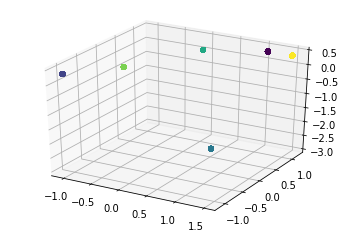

In [3]:
oper_data = []
for data in (my_data_001, my_data_002, my_data_003, my_data_004):
    oper_data.append(data.iloc[:,2:5])
oper_data = np.concatenate(oper_data)

sc = StandardScaler()
oper_data = sc.fit_transform(oper_data)

km = KMeans(6, random_state=seed)
clusters = km.fit_predict(oper_data)

start = 0
for data in (my_data_001, my_data_002, my_data_003, my_data_004):
    data['op_cluster'] = clusters[start:(start+len(data))]
    start += len(data)
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(oper_data[:,0], oper_data[:,1], oper_data[:,2], c=clusters)
plt.show()

<a name='tr_fe'></a>
#### Feature Engineering <a href='#TOC' style='text-decoration:none'>&#8593;</a>
Six variables counting the number of cycles spent by an engine in a given operating condition

In [4]:
c_001 = []
for batch_index in range(min(my_data_001[0]),max(my_data_001[0])+1):
    batch_subset = (my_data_001[0] == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_data_001.loc[batch_subset, 'op_cluster']:
        z[el] += 1
        c_001.append(z.copy())
c_001 = np.array(c_001)

c_002 = []
for batch_index in range(min(my_data_002[0]),max(my_data_002[0])+1):
    batch_subset = (my_data_002[0] == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_data_002.loc[batch_subset, 'op_cluster']:
        z[el] += 1
        c_002.append(z.copy())
c_002 = np.array(c_002)

c_003 = []
for batch_index in range(min(my_data_003[0]),max(my_data_003[0])+1):
    batch_subset = (my_data_003[0] == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_data_003.loc[batch_subset, 'op_cluster']:
        z[el] += 1
        c_003.append(z.copy())
c_003 = np.array(c_003)

c_004 = []
for batch_index in range(min(my_data_004[0]),max(my_data_004[0])+1):
    batch_subset = (my_data_004[0] == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_data_004.loc[batch_subset, 'op_cluster']:
        z[el] += 1
        c_004.append(z.copy())
c_004 = np.array(c_004)

<a name='tr_rul'></a>
#### Construction of the Target Feature (RUL) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [5]:
my_data_001['ttf'] = my_data_001.groupby([0])[1].transform(max)-my_data_001[1]
my_data_002['ttf'] = my_data_002.groupby([0])[1].transform(max)-my_data_002[1]
my_data_003['ttf'] = my_data_003.groupby([0])[1].transform(max)-my_data_003[1]
my_data_004['ttf'] = my_data_004.groupby([0])[1].transform(max)-my_data_004[1]

<a name='tr_dn'></a>
#### Data Normalization <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [6]:
def normalize(x):
    return (x - x.mean())/(x.std() + 1e-10)

In [7]:
X_001 = np.array(my_data_001.iloc[:,5:-1].groupby(['op_cluster']).apply(normalize))[:,:-1]
X_002 = np.array(my_data_002.iloc[:,5:-1].groupby(['op_cluster']).apply(normalize))[:,:-1]
X_003 = np.array(my_data_003.iloc[:,5:-1].groupby(['op_cluster']).apply(normalize))[:,:-1]
X_004 = np.array(my_data_004.iloc[:,5:-1].groupby(['op_cluster']).apply(normalize))[:,:-1]

<a name='tr_zvfr'></a>
#### Zero-Variance Features Removal <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [8]:
print('Zero-Variance Feature Indexes for each Dataset:\n')
print(np.where(X_001.std(axis=0)<0.0001),'\n',
np.where(X_002.std(axis=0)<0.0001),'\n',
np.where(X_003.std(axis=0)<0.0001),'\n',
np.where(X_004.std(axis=0)<0.0001))

Zero-Variance Feature Indexes for each Dataset:

(array([ 0,  4,  9, 15, 17, 18], dtype=int64),) 
 (array([17], dtype=int64),) 
 (array([ 0,  4, 15, 17, 18], dtype=int64),) 
 (array([17], dtype=int64),)


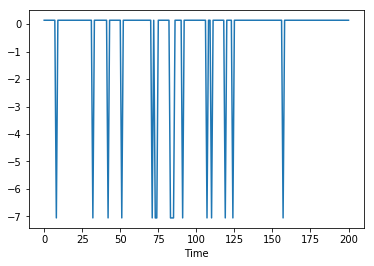

In [9]:
n_engine = 9
n_sens = 5 # even if this feature has no zero-variance, it has no predictive power
           # since it does not follow the monotonicity, prognosticability and trendability properties

plt.plot(X_001[my_data_001[0] == n_engine, n_sens])
plt.xlabel('Time')
plt.show()

In [10]:
# Removing the Zero-Variance Features

subset = np.where(X_001.std(axis=0)>0.0001)[0]
subset = subset[subset!=5]

X_001 = np.concatenate((np.array(my_data_001[0]).reshape(-1,1), X_001[:,subset],
                        c_001, np.array(my_data_001.ttf).reshape(-1,1)), axis=1)
X_002 = np.concatenate((np.array(my_data_002[0]).reshape(-1,1), X_002[:,subset],
                        c_002, np.array(my_data_002.ttf).reshape(-1,1)), axis=1)
X_003 = np.concatenate((np.array(my_data_003[0]).reshape(-1,1), X_003[:,subset],
                        c_003, np.array(my_data_003.ttf).reshape(-1,1)), axis=1)
X_004 = np.concatenate((np.array(my_data_004[0]).reshape(-1,1), X_004[:,subset],
                        c_004, np.array(my_data_004.ttf).reshape(-1,1)), axis=1)

print('Number of Zero-Variance Features for each Dataset:',
      sum(X_001.std(axis=0)<0.0001), sum(X_002.std(axis=0)<0.0001), 
      sum(X_003.std(axis=0)<0.0001), sum(X_004.std(axis=0)<0.0001))

Number of Zero-Variance Features for each Dataset: 5 0 5 0


The 5 zero-variance features in the first and in the third dataset are five of the six variables counting the number of cycles spent by an engine in a given operating condition. Indeed those two datasets have been simulated using only one specific operating condition.

<a name='tr_mwr'></a>
#### Moving Window & Reshape <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [11]:
h = 15
X_tot = []
y_tot = []
id_tot = []

for k, X in enumerate([X_001, X_002, X_003, X_004]):
    for i in range(0,int(max(X[:,0]))):
        subset_x = X[X[:,0] == (i+1),1:-1]
        subset_y = X[X[:,0] == (i+1),-1]
        for j in range(subset_x.shape[0] - h + 1):
            X_tot.append(subset_x[j:j+h,:])
            y_tot.append(subset_y[j+h-1])
            id_tot.append([k+1, i+1])
            
X_tot = np.array(X_tot)
y_tot = np.array(y_tot).reshape(-1,1)
id_tot = np.array(id_tot)
print('Training shapes:')
print(X_tot.shape, y_tot.shape, id_tot.shape)

Training shapes:
(150433, 15, 20) (150433, 1) (150433, 2)


<a name='tv_split'></a>
#### Training-Validation Split <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [12]:
# sn(n) function enables the extraction the observations belonging to the dataset n
# stv(n,p,val=False) function enables the training/validation division;
#                    the training set will have (100*p)% of the total observations

def sn(n):
    return id_tot[:,0] == n
    
def stv(n,p,val=False):
    if not val:
        return (id_tot[:,1] <= int(max(id_tot[sn(n), 1])*p)) & sn(n)
    else:
        return (id_tot[:,1] > int(max(id_tot[sn(n), 1])*p)) & sn(n)

In [13]:
split = 0.8

X_001_train = X_tot[stv(1,split)]
X_001_val = X_tot[stv(1,split,val=True)]
X_002_train = X_tot[stv(2,split)]
X_002_val = X_tot[stv(2,split,val=True)]
X_003_train = X_tot[stv(3,split)]
X_003_val = X_tot[stv(3,split,val=True)]
X_004_train = X_tot[stv(4,split)]
X_004_val = X_tot[stv(4,split,val=True)]

X_train = np.concatenate((X_001_train, X_002_train, X_003_train, X_004_train))
X_val = np.concatenate((X_001_val, X_002_val, X_003_val, X_004_val))

print('# training observations + # validation observations = # total observations ?')
print(X_train.shape[0] + X_val.shape[0] == X_tot.shape[0])

train_index = stv(1,split) | stv(2,split) | stv(3,split) | stv(4,split)
val_index = stv(1,split,val=True) | stv(2,split,val=True) | stv(3,split,val=True) | stv(4,split,val=True)

print('\n% of training and validation observations:')
print(sum(train_index)/X_tot.shape[0], sum(val_index)/X_tot.shape[0])

y_train, id_train = y_tot[train_index], id_tot[train_index]
y_val, id_val = y_tot[val_index], id_tot[val_index]

# training observations + # validation observations = # total observations ?
True

% of training and validation observations:
0.7987210253069473 0.20127897469305273


<a name='test_data_import'></a>
## Test Data Import <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [14]:
my_test_001 = pd.read_csv('data/test_FD001.txt', sep=' ', header=None, usecols=np.arange(26))
my_test_002 = pd.read_csv('data/test_FD002.txt', sep=' ', header=None, usecols=np.arange(26))
my_test_003 = pd.read_csv('data/test_FD003.txt', sep=' ', header=None, usecols=np.arange(26))
my_test_004 = pd.read_csv('data/test_FD004.txt', sep=' ', header=None, usecols=np.arange(26))

my_rul_001 = pd.read_csv('data/RUL_FD001.txt', sep=' ', header=None, usecols=np.arange(1))
my_rul_002 = pd.read_csv('data/RUL_FD002.txt', sep=' ', header=None, usecols=np.arange(1))
my_rul_003 = pd.read_csv('data/RUL_FD003.txt', sep=' ', header=None, usecols=np.arange(1))
my_rul_004 = pd.read_csv('data/RUL_FD004.txt', sep=' ', header=None, usecols=np.arange(1))

my_rul_001['id'] = my_rul_001.index+1
my_rul_002['id'] = my_rul_002.index+1
my_rul_003['id'] = my_rul_003.index+1
my_rul_004['id'] = my_rul_004.index+1

<a name='test_preprocessing'></a>
## Test Preprocessing (Thesis Section: 4.1) <a href='#TOC' style='text-decoration:none'>&#8593;</a>
<a name='te_rul'></a>
#### Test RUL Construction <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [15]:
test_sets = [my_test_001, my_test_002, my_test_003, my_test_004]
rul_sets = [my_rul_001, my_rul_002, my_rul_003, my_rul_004]
for i in range(4):
    test_sets[i] = test_sets[i].rename(columns = {0:'id'})
    temp = pd.DataFrame(test_sets[i].groupby('id')[1].max()).reset_index()
    temp.columns = ['id', 'max']
    rul_sets[i]['ttf'] = rul_sets[i][0] + temp['max']
    rul_sets[i].drop(0, axis=1, inplace=True)
    test_sets[i] = test_sets[i].merge(rul_sets[i], on='id', how='left')
    test_sets[i]['ttf'] = test_sets[i]['ttf'] - test_sets[i][1]
    
my_test_001, my_test_002, my_test_003, my_test_004 = test_sets

<a name='te_occ'></a>
#### Operating Conditions Clustering <a href='#TOC' style='text-decoration:none'>&#8593;</a>

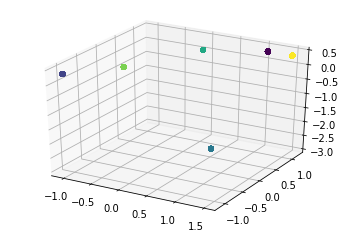

In [16]:
oper_data = []
for data in (my_test_001, my_test_002, my_test_003, my_test_004):
    oper_data.append(data.iloc[:,2:5])
oper_data = np.concatenate(oper_data)

oper_data = sc.transform(oper_data)

clusters = km.predict(oper_data)

start = 0
for data in (my_test_001, my_test_002, my_test_003, my_test_004):
    data[4] = clusters[start:(start+len(data))]
    start += len(data)
    
my_test_001 = my_test_001.rename(columns = {4:'cluster'})
my_test_002 = my_test_002.rename(columns = {4:'cluster'})
my_test_003 = my_test_003.rename(columns = {4:'cluster'})
my_test_004 = my_test_004.rename(columns = {4:'cluster'})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(oper_data[:,0], oper_data[:,1], oper_data[:,2], c=clusters)
plt.show()

<a name='te_fe'></a>
#### Feature Engineering <a href='#TOC' style='text-decoration:none'>&#8593;</a>
Six variables counting the number of cycles spent by an engine in a given operating condition

In [17]:
c_001 = []
for batch_index in range(min(my_test_001.id),max(my_test_001.id)+1):
    batch_subset = (my_test_001.id == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_test_001.loc[batch_subset, 'cluster']:
        z[el] += 1
        c_001.append(z.copy())
c_001 = np.array(c_001)

c_002 = []
for batch_index in range(min(my_test_002.id),max(my_test_002.id)+1):
    batch_subset = (my_test_002.id == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_test_002.loc[batch_subset, 'cluster']:
        z[el] += 1
        c_002.append(z.copy())
c_002 = np.array(c_002)

c_003 = []
for batch_index in range(min(my_test_003.id),max(my_test_003.id)+1):
    batch_subset = (my_test_003.id == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_test_003.loc[batch_subset, 'cluster']:
        z[el] += 1
        c_003.append(z.copy())
c_003 = np.array(c_003)

c_004 = []
for batch_index in range(min(my_test_004.id),max(my_test_004.id)+1):
    batch_subset = (my_test_004.id == batch_index)
    z = [0,0,0,0,0,0]
    for el in my_test_004.loc[batch_subset, 'cluster']:
        z[el] += 1
        c_004.append(z.copy())
c_004 = np.array(c_004)

<a name='te_dn'></a>
#### Data Normalization <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [18]:
X_001_test = np.array(my_test_001.iloc[:,4:-1].groupby(['cluster']).apply(normalize))[:,1:]
X_002_test = np.array(my_test_002.iloc[:,4:-1].groupby(['cluster']).apply(normalize))[:,1:]
X_003_test = np.array(my_test_003.iloc[:,4:-1].groupby(['cluster']).apply(normalize))[:,1:]
X_004_test = np.array(my_test_004.iloc[:,4:-1].groupby(['cluster']).apply(normalize))[:,1:]

<a name='te_zvfr'></a>
#### Zero-Variance Features Removal <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [19]:
X_001_test = np.concatenate((np.array(my_test_001['id']).reshape(-1,1), X_001_test[:,subset], 
                             c_001, np.array(my_test_001.ttf).reshape(-1,1)), axis=1)
X_002_test = np.concatenate((np.array(my_test_002['id']).reshape(-1,1), X_002_test[:,subset], 
                             c_002, np.array(my_test_002.ttf).reshape(-1,1)), axis=1)
X_003_test = np.concatenate((np.array(my_test_003['id']).reshape(-1,1), X_003_test[:,subset], 
                             c_003, np.array(my_test_003.ttf).reshape(-1,1)), axis=1)
X_004_test = np.concatenate((np.array(my_test_004['id']).reshape(-1,1), X_004_test[:,subset], 
                             c_004, np.array(my_test_004.ttf).reshape(-1,1)), axis=1)

<a name='te_mwr'></a>
#### Moving Window & Reshape <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [20]:
X_test = []
y_test = []
id_test = []

for k, X in enumerate([X_001_test, X_002_test, X_003_test, X_004_test]):
    for i in range(0,int(max(X[:,0]))):
        subset_x = X[X[:,0] == (i+1),1:-1]
        subset_y = X[X[:,0] == (i+1),-1]
        for j in range(subset_x.shape[0] - h + 1):
            X_test.append(subset_x[j:j+h,:])
            y_test.append(subset_y[j+h-1])
            id_test.append([k+1, i+1])

X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1,1)
id_test = np.array(id_test)
print('Test shapes:', X_test.shape, y_test.shape, id_test.shape)

Test shapes: (94999, 15, 20) (94999, 1) (94999, 2)


<a name='denoising'></a>
## Denoising Auto-Encoder (Thesis Sections: 4.2.1 and 5.1) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [21]:
inputs = keras.layers.Input((15,14))
x = keras.layers.GaussianNoise(10)(inputs)
x = keras.layers.GaussianDropout(0.5)(x)
x = keras.layers.Conv1D(16, kernel_size=3, padding='same')(x)
x = keras.layers.Activation('sigmoid')(x)
x = keras.layers.Conv1D(32, kernel_size=3, padding='same')(x)
latent_outputs = keras.layers.Activation('sigmoid')(x)

encoder = keras.models.Model(inputs, latent_outputs, name='encoder')

latent_inputs = keras.layers.Input((15,32))
x = keras.layers.Conv1D(16, kernel_size=3, padding='same')(latent_inputs)
x = keras.layers.Activation('sigmoid')(x)
outputs = keras.layers.Conv1D(14, kernel_size=3, padding='same')(x)

decoder = keras.models.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))

model = keras.models.Model(inputs, outputs)
model.add_loss(K.mean(keras.losses.mse(inputs, outputs)))
model.compile(optimizer='adam')

In [22]:
retrain = False # set retrain=True if you want to train the denoising auto-encoder
if retrain:
    
    json_string = model.to_json()
    with open('models/denoise.json', 'w') as outfile:
        json.dump(json_string, outfile)

    callbacks_list = [
        keras.callbacks.EarlyStopping(patience=15),
        keras.callbacks.ModelCheckpoint(filepath='models/denoise_weights.h5',
                                        save_best_only=True, save_weights_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.1)
        ]

    history = model.fit(X_train[:,:,:14], batch_size=256, epochs=250,
                        validation_data=(X_val[:,:,:14], None), callbacks=callbacks_list, verbose=0)

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [23]:
with open('models/denoise.json', 'r') as json_file:  
    json_string = json.load(json_file)

denoise_model = keras.models.model_from_json(json_string)
denoise_model.load_weights('models/denoise_weights.h5')
    
X_train_clean = denoise_model.predict(X_train[:,:,:14])
X_val_clean = denoise_model.predict(X_val[:,:,:14])
X_test_clean = denoise_model.predict(X_test[:,:,:14])

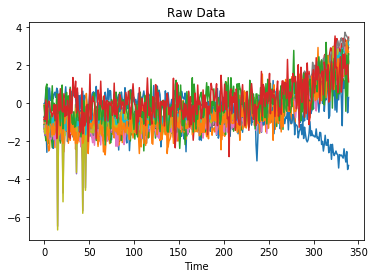

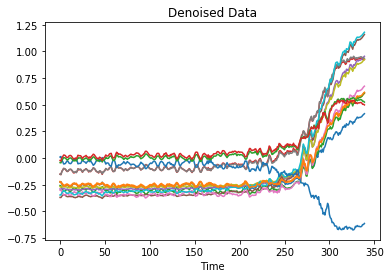

In [24]:
n_set = 4 # dataset number, can be modified (values from 1 to 4)
id_traj = 10 # trajectory number, can be modified (values range depends on the dataset number)
             # 1 --> 1:80        2 --> 1:208        3 --> 1:80        4 -- > 1:199

condition = (id_train[:,1] == id_traj) & (id_train[:,0] == n_set)

plt.plot(X_train[condition, -1, :14])
plt.xlabel('Time')
plt.title('Raw Data')
plt.show()

plt.plot(X_train_clean[condition, -1, :])
plt.xlabel('Time')
plt.title('Denoised Data')
plt.show()

<a name='hic'></a>
## Health Index Construction (Thesis Sections: 4.2.2 and 5.2) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [25]:
inputs = keras.layers.Input((14,))
x = keras.layers.Dense(8, activation='sigmoid')(inputs)
latent_outputs = keras.layers.Dense(2)(x)

encoder = keras.models.Model(inputs, latent_outputs, name='encoder')

latent_inputs = keras.layers.Input((2,))
x = keras.layers.Dense(8, activation='sigmoid')(latent_inputs)
outputs = keras.layers.Dense(14)(x)

decoder = keras.models.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))

model = keras.models.Model(inputs, outputs)
model.add_loss(K.mean(keras.losses.mse(inputs, outputs)))
model.compile(optimizer='adam')

In [26]:
retrain = False # set retrain=True if you want to train the HI auto-encoder
if retrain:
    
    json_string = model.to_json()
    with open('models/hi.json', 'w') as outfile:
        json.dump(json_string, outfile)

    callbacks_list = [
        keras.callbacks.EarlyStopping(patience=6),
        keras.callbacks.ModelCheckpoint(filepath='models/hi_weights.h5',
                                        save_best_only=True, save_weights_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.1)
        ]

    history = model.fit(X_train_clean[:,-1,:], batch_size=256, epochs=250,
                        validation_data=(X_val_clean[:,-1,:], None), callbacks=callbacks_list, verbose = 0)

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [27]:
with open('models/hi.json', 'r') as json_file:  
    json_string = json.load(json_file)

hi_model = keras.models.model_from_json(json_string)
hi_model.load_weights('models/hi_weights.h5')

hi_encoder = hi_model.layers[1]

hi_train = hi_encoder.predict(X_train_clean[:,-1,:])
hi_val = hi_encoder.predict(X_val_clean[:,-1,:])
hi_test = hi_encoder.predict(X_test_clean[:,-1,:])

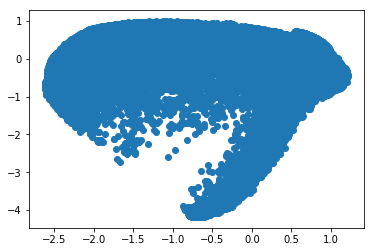

In [28]:
sc = StandardScaler()
hi_train = sc.fit_transform(hi_train)
hi_val = sc.transform(hi_val)
hi_test = sc.transform(hi_test)

plt.scatter(hi_train[:,0], hi_train[:,1])
plt.show()

<a name='hsd'></a>
## Health Stages Division (Thesis Sections: 4.3 and 5.3) <a href='#TOC' style='text-decoration:none'>&#8593;</a>
<a name='resampling'></a>
#### Re-Sampling (Thesis Section: 5.3.3) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

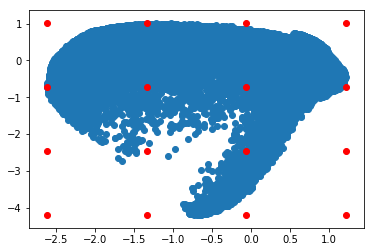

In [29]:
x_grid = np.linspace(hi_train.min(axis=0)[0], hi_train.max(axis=0)[0], 4)
y_grid = np.linspace(hi_train.min(axis=0)[1], hi_train.max(axis=0)[1], 4)

plt.scatter(hi_train[:,0], hi_train[:,1])
for el in x_grid:
    plt.scatter(np.repeat(el, len(y_grid)), y_grid, c='red')

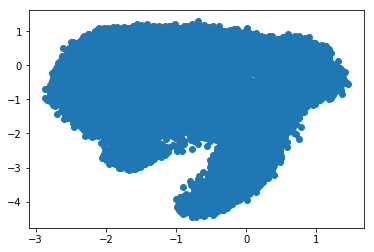

In [30]:
np.random.seed(seed)
subset_resample = []
density = 0.1
scale = 2
for i in range(len(x_grid)-1):        
    x_cond = (hi_train[:,0] >= x_grid[i]) & (hi_train[:,0] < x_grid[i+1])
    for j in range(len(y_grid)-1):
        y_cond = (hi_train[:,1] >= y_grid[j]) & (hi_train[:,1] < y_grid[j+1])
        sample = hi_train[x_cond & y_cond]
        if (len(sample)/len(hi_train)) > density:
            sample = sample[np.random.choice(len(sample),
                                             int(density*len(hi_train)), replace=True)] 
            sample += np.array([np.random.normal(scale=0.1) for i in range(2*len(sample))]).reshape(-1,2)
        elif len(sample) != 0:
            sample = sample[np.random.choice(len(sample),
                                             max(len(sample), int(density/scale*len(hi_train))), replace=True)] 
            sample += np.array([np.random.normal(scale=0.1) for i in range(2*len(sample))]).reshape(-1,2)
        subset_resample.append(sample)
subset_resample = np.concatenate(subset_resample)

plt.scatter(subset_resample[:,0], subset_resample[:,1])
plt.show()

<a name='clustering'></a>
#### Clustering (Thesis Sections: 5.3.1 and 5.3.2) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [31]:
resample = False
n_comp = 3
clust_tech = 'gm'

if clust_tech == 'km':
    km = KMeans(n_comp, random_state=seed)
    if resample:
        km.fit(subset_resample)
        clusters_train = km.predict(hi_train)
    else:
        clusters_train = km.fit_predict(hi_train)
    clusters_val = km.predict(hi_val)
    clusters_test = km.predict(hi_test)
else:
    gm = GaussianMixture(n_comp, random_state=seed)
    if resample:
        gm.fit(subset_resample)
        clusters_train = gm.predict(hi_train)
    else:
        clusters_train = gm.fit_predict(hi_train)
    clusters_val = gm.predict(hi_val)
    clusters_test = gm.predict(hi_test)

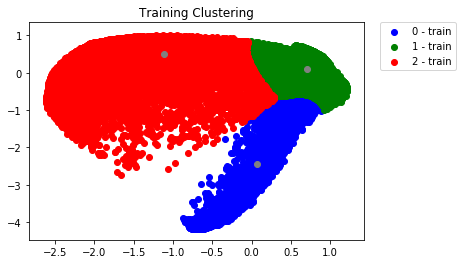

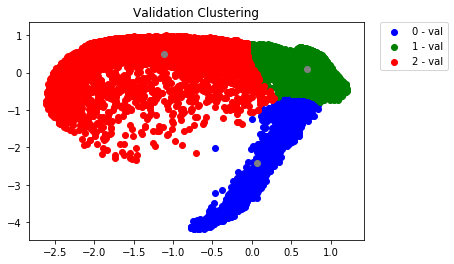

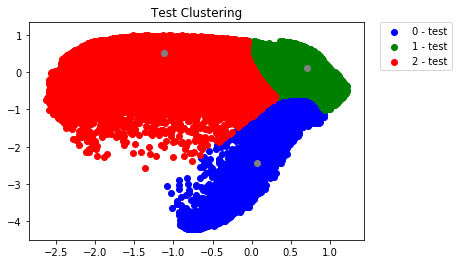

In [32]:
fig, ax = plt.subplots()
ax.scatter(hi_train[clusters_train == 0, 0], hi_train[clusters_train == 0, 1], c='blue', label = '0 - train')
ax.scatter(hi_train[clusters_train == 1, 0], hi_train[clusters_train == 1, 1], c='green', label = '1 - train')
ax.scatter(hi_train[clusters_train == 2, 0], hi_train[clusters_train == 2, 1], c='red', label = '2 - train')
#ax.scatter(hi_train[clusters_train == 3, 0], hi_train[clusters_train == 3, 1], c='yellow', label = '3 - train')
if clust_tech == 'km':
    ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='grey')
else:
    ax.scatter(gm.means_[:,0], gm.means_[:,1], c='grey')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training Clustering')
plt.show()

fig, ax = plt.subplots()
ax.scatter(hi_val[clusters_val == 0, 0], hi_val[clusters_val == 0, 1], c='blue', label = '0 - val')
ax.scatter(hi_val[clusters_val == 1, 0], hi_val[clusters_val == 1, 1], c='green', label = '1 - val')
ax.scatter(hi_val[clusters_val == 2, 0], hi_val[clusters_val == 2, 1], c='red', label = '2 - val')
#ax.scatter(hi_val[clusters_val == 3, 0], hi_val[clusters_val == 3, 1], c='yellow', label = '3 - val')
if clust_tech == 'km':
    ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='grey')
else:
    ax.scatter(gm.means_[:,0], gm.means_[:,1], c='grey')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Validation Clustering')
plt.show()

fig, ax = plt.subplots()
ax.scatter(hi_test[clusters_test == 0, 0], hi_test[clusters_test == 0, 1], c='blue', label = '0 - test')
ax.scatter(hi_test[clusters_test == 1, 0], hi_test[clusters_test == 1, 1], c='green', label = '1 - test')
ax.scatter(hi_test[clusters_test == 2, 0], hi_test[clusters_test == 2, 1], c='red', label = '2 - test')
#ax.scatter(hi_test[clusters_test == 3, 0], hi_test[clusters_test == 3, 1], c='yellow', label = '3 - test')
if clust_tech == 'km':
    ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='grey')
else:
    ax.scatter(gm.means_[:,0], gm.means_[:,1], c='grey')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Test Clustering')
plt.show()

<a name='check'></a>
#### Validity Check on a Trajectory <a href='#TOC' style='text-decoration:none'>&#8593;</a>

Health Cluster Number: 1


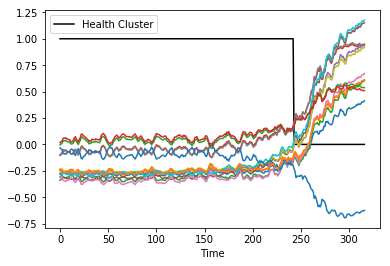

In [33]:
n_set = 4 # dataset number, can be modified (values from 1 to 4)
id_traj = 6 # trajectory number, can be modified (values range depends on the dataset number)
             # 1 --> 1:80        2 --> 1:208        3 --> 1:80        4 -- > 1:199
    
condition = (id_train[:,1] == id_traj) & (id_train[:,0] == n_set)

cl_h = clusters_train[condition][0]
print('Health Cluster Number:', cl_h)

plt.plot(clusters_train[condition], c='black', label='Health Cluster')
plt.plot(X_train_clean[condition, -1, :])
plt.xlabel('Time')
plt.legend()
plt.show()

<a name='feat_eng'></a>
## Feature Engineering <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [34]:
num_uh_train = 0
hi_diff_train = np.zeros(hi_train.shape)
cycles_train = np.zeros(hi_train.shape[0]).reshape(-1,1)
y_train_ = []

for n_set in range(1,5):
    condition = id_train[:,0] == n_set
    for n_obs in range(min(id_train[condition,1]),max(id_train[condition,1])+1):
        subset = hi_train[condition & (id_train[:,1] == n_obs)]
        cl_subset = clusters_train[condition & (id_train[:,1] == n_obs)]
        if cl_subset[-1] == cl_h:
            num_uh_train += 1
            
        start_count = False
        cyc = []
        count = 0
        for i,el in enumerate(cl_subset):
            if not start_count and el != cl_h:
                start_count = True
                max_rul = y_train[condition & (id_train[:,1] == n_obs)][i]
            if start_count:
                count += 1
            cyc.append(count)
            
        # the difference between the current HI and the HI at the beginning of the engine lifetime
        hi_diff_train[condition & (id_train[:,1] == n_obs)] = subset - subset[0]
        
        # the number of cycles passed from the detection of the change point in the degradation trend
        cycles_train[condition & (id_train[:,1] == n_obs)] = np.array(cyc).reshape(-1,1)
        
        if y_train[condition & (id_train[:,1] == n_obs)][0] == max_rul:
            y_train_.append(y_train[condition & (id_train[:,1] == n_obs), 0])
        else:
            y_train_.append(np.concatenate([np.repeat(max_rul, sum(np.array(cyc) == 0)),
                                                y_train[condition & (id_train[:,1] == n_obs), 0][np.array(cyc) != 0]])) 
            
y_train_ = np.concatenate(y_train_).reshape(-1,1)

In [35]:
num_uh_val = 0
hi_diff_val = np.zeros(hi_val.shape)
cycles_val = np.zeros(hi_val.shape[0]).reshape(-1,1)
y_val_ = []

for n_set in range(1,5):
    condition = id_val[:,0] == n_set
    for n_obs in range(min(id_val[condition,1]),max(id_val[condition,1])+1):
        subset = hi_val[condition & (id_val[:,1] == n_obs)]
        cl_subset = clusters_val[condition & (id_val[:,1] == n_obs)]
        if cl_subset[-1] == cl_h:
            num_uh_val += 1
            
        start_count = False
        cyc = []
        count = 0
        for i,el in enumerate(cl_subset):
            if not start_count and el != cl_h:
                start_count = True
                max_rul = y_val[condition & (id_val[:,1] == n_obs)][i]
            if start_count:
                count += 1
            cyc.append(count)
        
        # the difference between the current HI and the HI at the beginning of the engine lifetime
        hi_diff_val[condition & (id_val[:,1] == n_obs)] = subset - subset[0]
        
        # the number of cycles passed from the detection of the change point in the degradation trend
        cycles_val[condition & (id_val[:,1] == n_obs)] = np.array(cyc).reshape(-1,1)
        
        if y_val[condition & (id_val[:,1] == n_obs)][0] == max_rul:
            y_val_.append(y_val[condition & (id_val[:,1] == n_obs), 0])
        else:
            y_val_.append(np.concatenate([np.repeat(max_rul, sum(np.array(cyc) == 0)),
                                              y_val[condition & (id_val[:,1] == n_obs), 0][np.array(cyc) != 0]]))

y_val_ = np.concatenate(y_val_).reshape(-1,1)

In [36]:
num_uh_test = 0
hi_diff_test = np.zeros(hi_test.shape)
cycles_test = np.zeros(hi_test.shape[0]).reshape(-1,1)

for n_set in range(1,5):
    condition = id_test[:,0] == n_set
    for n_obs in range(min(id_test[condition,1]),max(id_test[condition,1])+1):
        subset = hi_test[condition & (id_test[:,1] == n_obs)]
        cl_subset = clusters_test[condition & (id_test[:,1] == n_obs)]
        if cl_subset[-1] == cl_h:
            num_uh_test += 1
            
        start_count = False
        cyc = []
        count = 0
        for el in cl_subset:
            if not start_count and el != cl_h:
                start_count = True
            if start_count:
                count += 1
            cyc.append(count)
        
        # the difference between the current HI and the HI at the beginning of the engine lifetime
        hi_diff_test[condition & (id_test[:,1] == n_obs)] = subset - subset[0]
        
        # the number of cycles passed from the detection of the change point in the degradation trend
        cycles_test[condition & (id_test[:,1] == n_obs)] = np.array(cyc).reshape(-1,1)

In [37]:
print('Number of trajectories ending healthy:\n\nTraining\tValidation\tTest')
print('', num_uh_train, '\t\t', num_uh_val, '\t\t', num_uh_test)

Number of trajectories ending healthy:

Training	Validation	Test
 0 		 0 		 173


<a name='gbm'></a>
## Gradient Boosting Machine - GBM (Thesis Sections: 4.4.1 and 5.4) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [38]:
max_rul = 130
y_pw = np.concatenate([y_train, y_val])
y_pw[y_pw > max_rul] = max_rul

c_train = X_train[:,-1,14:]
c_val = X_val[:,-1,14:]
c_test = X_test[:,-1,14:]

c_diff_train = np.where(c_train - X_train[:,-2,14:])[1].reshape(-1,1)
c_diff_val = np.where(c_val - X_val[:,-2,14:])[1].reshape(-1,1)
c_diff_test = np.where(c_test - X_test[:,-2,14:])[1].reshape(-1,1)

feat_train = np.concatenate([hi_train, hi_diff_train, cycles_train,
                          c_diff_train, clusters_train.reshape(-1,1),
                          c_train.sum(axis=-1).reshape(-1,1)], axis=-1)
feat_val = np.concatenate([hi_val, hi_diff_val, cycles_val,
                        c_diff_val, clusters_val.reshape(-1,1),
                        c_val.sum(axis=-1).reshape(-1,1)], axis=-1)
feat_test = np.concatenate([hi_test, hi_diff_test, cycles_test,
                         c_diff_test, clusters_test.reshape(-1,1),
                         c_test.sum(axis=-1).reshape(-1,1)], axis=-1)
feat_pw = np.concatenate([feat_train, feat_val])

In [39]:
retrain = False # set retrain=True if you want to find another sub-optimal solution of the GBM parameters
if retrain:
    
    param_grid = {'learning_rate':scipy.stats.uniform(0.01,0.20),
                 'max_leaf_nodes':scipy.stats.randint(8,33),
                 'max_features':scipy.stats.uniform(0.1,0.8),
                 'min_samples_leaf':scipy.stats.randint(50,151),
                 'max_depth':scipy.stats.randint(3,7),
                 'subsample':scipy.stats.uniform(0.1,0.8),
                 #-----------------------------------
                 'n_estimators':[1000],
                 'random_state':[seed],
                 'validation_fraction':[0.1],
                 'n_iter_no_change':[10]
                 }

    cv_model = RandomizedSearchCV(estimator=GradientBoostingRegressor(loss='ls'), param_distributions=param_grid, n_iter=250,
                               scoring='neg_mean_squared_error', n_jobs=-1, iid=False, cv=5, verbose=2)

    cv_model.fit(feat_pw, y_pw)
    joblib.dump(cv_model.best_params_, 'models/gbm_params.joblib')
    
best_params = joblib.load('models/gbm_params.joblib')
print('Best Parameters:\n', best_params)

Best Parameters:
 {'learning_rate': 0.039557764080168485, 'max_depth': 5, 'max_features': 0.6727368269702841, 'max_leaf_nodes': 24, 'min_samples_leaf': 85, 'n_estimators': 1000, 'n_iter_no_change': 10, 'random_state': 42, 'subsample': 0.7050219834170616, 'validation_fraction': 0.1}


In [40]:
retrain = False # set retrain=True if you want to train 61 GBM models
if retrain:
    
    gbms = []
    ruls = []    
    for i in range(100,161):
        y_train_max = y_train.copy()
        y_train_max[y_train_max > i] = i
        my_model = GradientBoostingRegressor(loss='ls')
        for k,v in best_params.items():
            setattr(my_model,k,v)
        my_model.fit(feat_train, y_train_max)
        gbms.append(my_model)
        ruls.append(i)    
    joblib.dump((gbms, ruls), 'models/gbms_and_ruls.joblib')
    
gbms, ruls = joblib.load('models/gbms_and_ruls.joblib')

<a name='truncated'></a>
#### Truncated Validation Set (Thesis Section: 5.4.2) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

Number of new trajectories: 710
Min(last_RUL): 42.924883052821784 
Max(last_RUL): 245.29597748934677


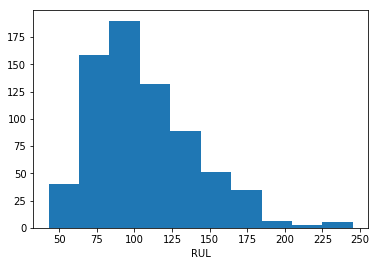

In [41]:
np.random.seed(seed)
X_trunc_val = []
y_trunc_val = []
id_trunc_val = []
last_ones = []
n_iter = 5

for k in range(n_iter):
    X_sub_val = []
    y_sub_val = []
    id_sub_val = []
    for n_set in range(1,5):
        condition = id_val[:,0] == n_set
        for n_obs in  range(min(id_val[condition,1]),max(id_val[condition,1])+1):
            last_one = len(y_val[condition & (id_val[:,1] == n_obs)])/2 + np.random.normal(0,10)
            subset = (y_val[condition & (id_val[:,1] == n_obs)] > last_one).reshape(-1)
            X_sub_val.append(feat_val[condition & (id_val[:,1] == n_obs)][subset,:])
            y_sub_val.append(y_val[condition & (id_val[:,1] == n_obs)][subset,:])
            id_sub_val.append(id_val[condition & (id_val[:,1] == n_obs)][subset,:])
            if sum(subset)!=0:
                last_ones.append(last_one)
    X_sub_val = np.concatenate(X_sub_val)
    y_sub_val = np.concatenate(y_sub_val)
    id_sub_val = np.concatenate(id_sub_val)
    X_trunc_val.append(X_sub_val)
    y_trunc_val.append(y_sub_val)
    id_trunc_val.append(id_sub_val)
    
print('Number of new trajectories:', len(last_ones))
print('Min(last_RUL):', min(last_ones), '\nMax(last_RUL):', max(last_ones))
plt.hist(last_ones)
plt.xlabel('RUL')
plt.show()

Optimal max_RUL: 135


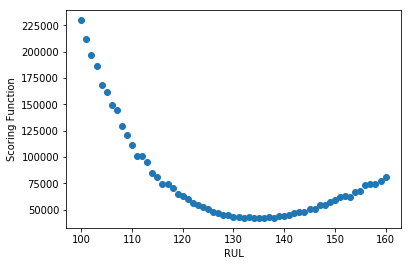

In [42]:
retrain = False # set retrain=True if you want to evaluate the performances of 61 GBM models
if retrain:
    
    factor = 0.95
    results = []
    for i,model in enumerate(gbms):
        last_scoring = []
        for k in range(n_iter):
            X_sub_val = X_trunc_val[k]
            y_sub_val = y_trunc_val[k]
            id_sub_val = id_trunc_val[k]
            preds = model.predict(X_sub_val)
            for n_set in range(1,5):
                condition = id_sub_val[:,0] == n_set
                for batch_index in range(min(id_sub_val[condition,1]),max(id_sub_val[condition,1])+1):
                    batch_subset = condition & (id_sub_val[:,1] == batch_index)
                    if sum(batch_subset)!=0:
                        RUL = y_sub_val[batch_subset,0]
                        pred = preds[batch_subset]
                        prec = pred[0]
                        pred_exp = []
                        for x in pred:
                            pred_exp.append(prec*factor + x*(1-factor))
                            prec = pred_exp[-1]
                        pred_exp = np.array(pred_exp)
                        prec = pred_exp[0]
                        pred_exp_2 = []
                        for x in pred_exp:
                            pred_exp_2.append(2*x - (prec*factor + x*(1-factor)))
                            prec = pred_exp_2[-1]
                        pred_exp_2 = np.array(pred_exp_2)    
                        error = (pred_exp_2 - RUL)[-1]
                        if error >= 0:
                            last_scoring.append(np.exp(error/10) - 1)
                        else:
                            last_scoring.append(np.exp(-error/13) - 1)
        results.append(sum(last_scoring))        
    joblib.dump(results, 'models/ruls_results.joblib')

results = joblib.load('models/ruls_results.joblib')
max_rul = ruls[np.argmin(results)]
print('Optimal max_RUL:', max_rul)
plt.scatter(ruls, results)
plt.xlabel('RUL')
plt.ylabel('Scoring Function')
plt.show()

<a name='point_eval'></a>
## Point Evaluation (Thesis Section: 6.1) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [43]:
retrain = False # set retrain=True if you want to train the final GBM model

y_pw = np.concatenate([y_train, y_val])
y_pw[y_pw > max_rul] = max_rul

if retrain:
    my_model = GradientBoostingRegressor(loss='ls')
    for k,v in best_params.items():
        setattr(my_model,k,v)
    my_model.fit(feat_pw, y_pw)
    joblib.dump(my_model, 'models/gbm_model.joblib')
else:
    my_model = joblib.load('models/gbm_model.joblib')

preds = my_model.predict(feat_test)
preds[preds < 0] = 0

In [44]:
factor = 0.95

for n_set in range(1,5):
    last_scoring = []
    last_rs = []
    last_mse = []
    last_mae = []
    last_mape = []
    condition = id_test[:,0] == n_set
    for batch_index in range(min(id_test[condition,1]),max(id_test[condition,1])+1):
        batch_subset = condition & (id_test[:,1] == batch_index)
        t = np.arange(sum(batch_subset))
        RUL = y_test[batch_subset,0]
        pred = preds[batch_subset]
        prec = pred[0]
        pred_exp = []
        for x in pred:
            pred_exp.append(prec*factor + x*(1-factor))
            prec = pred_exp[-1]
        pred_exp = np.array(pred_exp)   
        prec = pred_exp[0]
        pred_exp_2 = []
        for x in pred_exp:
            pred_exp_2.append(2*x - (prec*factor + x*(1-factor)))
            prec = pred_exp_2[-1]
        pred_exp_2 = np.array(pred_exp_2)    
        error = (pred_exp_2 - RUL)[-1]    
        if error >= 0:
            last_scoring.append(np.exp(error/10) - 1)
            last_rs.append((np.exp(error/10) - 1)/RUL[-1])
        else:
            last_scoring.append(np.exp(-error/13) - 1)
            last_rs.append((np.exp(-error/13) - 1)/RUL[-1])
        last_mse.append(np.square(error))
        last_mae.append(np.abs(error))
        last_mape.append(np.abs(error)/RUL[-1])

    print('Test Set FD00' + str(n_set) + ':')
    print('\tScoring', sum(last_scoring))
    print('\tRelative Scoring', sum(last_rs))
    print('\tMSE', sum(last_mse)/len(last_mse))
    print('\tRMSE', np.sqrt(sum(last_mse)/len(last_mse)))
    print('\tMAE', sum(last_mae)/len(last_mae))
    print('\tMAPE', sum(last_mape)/len(last_mape), '\n')

Test Set FD001:
	Scoring 534.891070741499
	Relative Scoring 6.529664366246803
	MSE 344.0411804010647
	RMSE 18.548347106981385
	MAE 14.087523858702493
	MAPE 0.21033030366927893 

Test Set FD002:
	Scoring 3869.5478918237163
	Relative Scoring 44.54220058660587
	MSE 570.6984425762797
	RMSE 23.88929556467247
	MAE 17.771386655028667
	MAPE 0.34931482630368715 

Test Set FD003:
	Scoring 653.1519973485688
	Relative Scoring 14.940174247844158
	MSE 330.5118684874483
	RMSE 18.179985381937144
	MAE 13.61332882632151
	MAPE 0.3066394609856894 

Test Set FD004:
	Scoring 6373.192331260775
	Relative Scoring 78.88522531340081
	MSE 812.5708538559307
	RMSE 28.505628459234693
	MAE 21.67593712241125
	MAPE 0.4323291835876172 



<a name='wnn'></a>
## Weibull Neural Network (Thesis Sections: 4.4.2 and 5.5) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [45]:
scaler = MinMaxScaler()
feat_train = scaler.fit_transform(feat_train)
feat_val = scaler.transform(feat_val)

y_train_ = np.concatenate([y_train_, np.ones(y_train_.shape)], axis=-1)

tte_mean_train = np.mean(y_train_[:,0])
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
mean_u = np.mean(y_train_[:,1])
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'\nmean uncensored: ',mean_u)

init_alpha:  75.07018177306547 
mean uncensored:  1.0


In [46]:
inputs = keras.layers.Input((feat_train.shape[-1],))
x = keras.layers.Dense(32, activation='sigmoid')(inputs)
x = keras.layers.Dense(64, activation='sigmoid')(x)
x = keras.layers.Dense(2)(x)
outputs = keras.layers.Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha, "max_beta_value":4.0})(x)

model = keras.models.Model(inputs, outputs)
loss = wtte.Loss(kind='discrete').loss_function
model.compile(loss=loss, optimizer='adam')

In [47]:
retrain = False # set retrain=True if you want to train the Weibull NN
if retrain:
    
    callbacks_list = [
        keras.callbacks.EarlyStopping(patience=4),
        keras.callbacks.ModelCheckpoint(filepath='models/weibull_weights.h5',
                                        save_best_only=True, save_weights_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1)
        ]
    
    history = model.fit(feat_train, y_train_, batch_size=128, epochs=250,
                        validation_split=0.1, callbacks=callbacks_list, verbose=0)

model.load_weights('models/weibull_weights.h5')
preds = model.predict(feat_val)

<a name='prognostic_eval'></a>
## Prognostic Evaluation (Thesis Section: 6.3) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

In [48]:
n_set = 1 # dataset number, can be modified (values from 1 to 4)
id_traj = 100 # trajectory number, can be modified (values range depends on the dataset number)
             # 1 --> 1:100       2 --> 1:260        3 --> 1:100        4 -- > 1:249

<a name='example'></a>
#### Example of Prediction <a href='#TOC' style='text-decoration:none'>&#8593;</a>

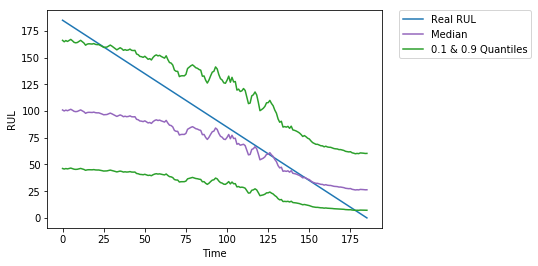

In [49]:
traj = preds[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
rul = y_val[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]

plt.plot(rul, label='Real RUL')
plt.plot(weibull.quantiles(traj[:,0], traj[:,1], 0.9), c='C2')
plt.plot(weibull.quantiles(traj[:,0], traj[:,1], 0.5), c='C4', label='Median')
plt.plot(weibull.quantiles(traj[:,0], traj[:,1], 0.1), c='C2', label='0.1 & 0.9 Quantiles')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('RUL')
plt.show()

<a name='ph'></a>
#### Prediction Horizon (Thesis Section: 6.3.1) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

Prediction Horizon = 46


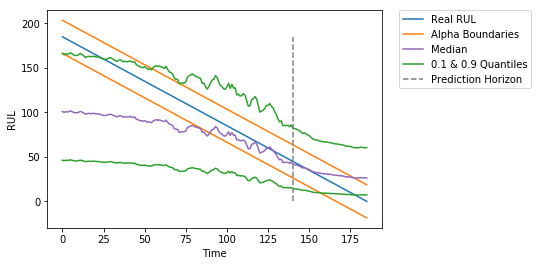

In [50]:
set_alpha = 0.1
set_beta = 0.5

traj = preds[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
rul = y_val[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
alpha_minus = rul - set_alpha*len(rul)
alpha_plus = rul + set_alpha*len(rul)
probs = np.array([weibull.cdf(alpha_plus[t],traj[t,0],traj[t,1]) -
                  weibull.cdf(max(0,alpha_minus[t]),traj[t,0],traj[t,1]) for t in range(len(rul))])
ph = len(rul) - np.where(probs >= set_beta)[0][0]

print('Prediction Horizon =', ph)
plt.plot(alpha_plus, c='C1')
plt.plot(rul, label='Real RUL')
plt.plot(alpha_minus, c='C1', label='Alpha Boundaries')
plt.plot(weibull.quantiles(traj[:,0], traj[:,1], 0.9), c='C2')
plt.plot(weibull.quantiles(traj[:,0], traj[:,1], 0.5), c='C4', label='Median')
plt.plot(weibull.quantiles(traj[:,0], traj[:,1], 0.1), c='C2', label='0.1 & 0.9 Quantiles')
plt.plot(np.repeat(len(rul) - ph, len(rul)), np.arange(len(rul)), 'C7--', label='Prediction Horizon')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('RUL')
plt.show()

<a name='alp'></a>
#### alpha-lambda Performance (Thesis Section: 6.3.2) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

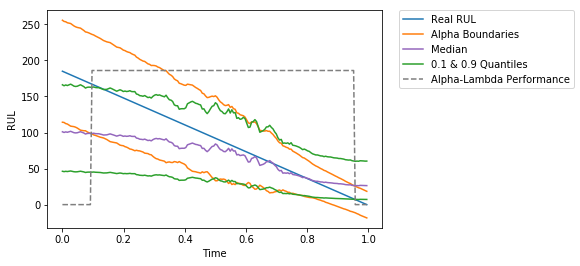

In [51]:
set_alpha = 0.7
set_beta = 0.5

traj = preds[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
rul = y_val[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
rul_hat = weibull.quantiles(traj[:,0], traj[:,1], 0.5).reshape(-1,1)
alpha_minus = rul - set_alpha*rul_hat
alpha_plus = rul + set_alpha*rul_hat
probs = np.array([weibull.cdf(alpha_plus[t],traj[t,0],traj[t,1]) - 
                  weibull.cdf(max(0,alpha_minus[t]),traj[t,0],traj[t,1]) for t in range(len(rul))])
binary = probs > set_beta
lambdas = np.arange(len(rul))/len(rul)

plt.plot(lambdas, alpha_plus, c='C1')
plt.plot(lambdas, rul, label='Real RUL')
plt.plot(lambdas, alpha_minus, c='C1', label='Alpha Boundaries')
plt.plot(lambdas, weibull.quantiles(traj[:,0], traj[:,1], 0.9), c='C2')
plt.plot(lambdas, weibull.quantiles(traj[:,0], traj[:,1], 0.5), c='C4', label='Median')
plt.plot(lambdas, weibull.quantiles(traj[:,0], traj[:,1], 0.1), c='C2', label='0.1 & 0.9 Quantiles')
plt.plot(lambdas, binary*len(rul), 'C7--', label='Alpha-Lambda Performance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('RUL')
plt.show()

<a name='rcra'></a>
#### Relative & Cumulative Relative Accuracy (Thesis Section: 6.3.3) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

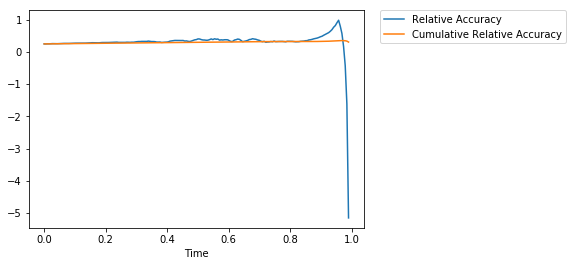

In [52]:
traj = preds[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
rul = y_val[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
rul_hat = weibull.quantiles(traj[:,0], traj[:,1], 0.1).reshape(-1,1)
ras = 1 - np.abs(rul - rul_hat)/rul
cras = np.zeros(ras.shape)
tot = 0
for i,el in enumerate(ras):
    tot += el
    cras[i] = tot/(i+1)
lambdas = np.arange(len(rul))/len(rul)

plt.plot(lambdas, ras, label='Relative Accuracy')
plt.plot(lambdas, cras, label='Cumulative Relative Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.show()

<a name='convergence'></a>
#### Convergence (Thesis Section: 6.3.4) <a href='#TOC' style='text-decoration:none'>&#8593;</a>

Convergene index = 58.2126226835105


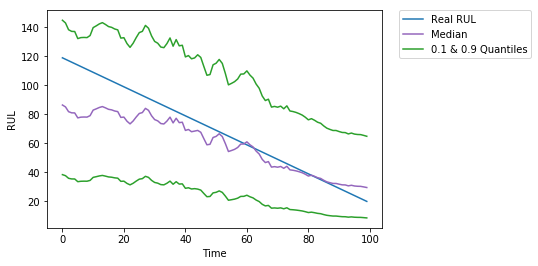

In [53]:
set_alpha = 0.1
n_steps = 100
eoup = 20

traj = preds[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
rul = y_val[(id_val[:,0] == n_set) & (id_val[:,1] == id_traj)]
alpha_minus = rul - set_alpha*len(rul)
alpha_plus = rul + set_alpha*len(rul)
start = len(rul) - n_steps - eoup
stop = len(rul) - eoup
probs = np.array([weibull.cdf(alpha_plus[t],traj[t,0],traj[t,1]) -
                  weibull.cdf(max(0,alpha_minus[t]),traj[t,0],traj[t,1]) for t in range(start, stop)])
num_x = np.array([((i+1)**2 - i**2)*probs[i] for i in range(len(probs))]).sum()/2
num_y = np.array([probs[i]**2 for i in range(len(probs))]).sum()/2
den = np.array([probs[i] for i in range(len(probs))]).sum()
xc = num_x /den
yc = num_y / den

print('Convergene index =', (xc**2 + yc**2)**0.5)
plt.plot(rul[start:stop], label='Real RUL')
plt.plot(weibull.quantiles(traj[start:stop,0], traj[start:stop,1], 0.9), c='C2')
plt.plot(weibull.quantiles(traj[start:stop,0], traj[start:stop,1], 0.5), c='C4', label='Median')
plt.plot(weibull.quantiles(traj[start:stop,0], traj[start:stop,1], 0.1), c='C2', label='0.1 & 0.9 Quantiles')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('RUL')
plt.show()